# Import libraries


In [1]:
import pandas as pd
import requests
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
import ppscore as pps
from sklearn.cluster import KMeans

# Import Invasive Species Data and prepare for analysis


In [2]:
# Read the CSV file into a pandas DataFrame
all_data = pd.read_csv('data/PRESENCE_LINE_2023_10_26_120650800.csv')

# Show the properties of the DataFrame
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   centroid_x                       2683 non-null   float64
 1   centroid_y                       2683 non-null   float64
 2   scientific_name                  2683 non-null   object 
 3   common_name                      2683 non-null   object 
 4   observation_date                 2683 non-null   object 
 5   number_found                     1183 non-null   float64
 6   observer                         2683 non-null   object 
 7   organization_name                1422 non-null   object 
 8   confirmed_ind                    2683 non-null   bool   
 9   species_id_method_name_array     2628 non-null   object 
 10  species_verified_by_name         1579 non-null   object 
 11  follow_up_name                   47 non-null     object 
 12  evaluation_type_name

# Filtering the Data

In [3]:
# Filter the DataFrame to only include New York and Common reed grass, phragmites
filtered_data = all_data[(all_data['jurisdiction'] == 'New York') & (
    all_data['common_name'] == 'Common reed grass, phragmites')]

# Rename the columns to be more descriptive
filtered_data = filtered_data.rename(
    columns={'centroid_x': 'longitude', 'centroid_y': 'latitude'})

# Filter the DataFrame to only include the columns we need
filtered_data = filtered_data.loc[:, ['longitude', 'latitude',
                                      'observation_date', 'number_found', 'imap_id', 'county', 'uuid']]

# Convert the observation_date column to a datetime object
filtered_data['observation_date'] = pd.to_datetime(
    filtered_data['observation_date'], format='%d-%b-%Y')

# Sort the DataFrame by date
filtered_data = filtered_data.sort_values('observation_date', ascending=True)

# Show the properties of the DataFrame
filtered_data.info()

# Show the first 5 rows of the DataFrame
filtered_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 611 entries, 1481 to 1995
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   longitude         611 non-null    float64       
 1   latitude          611 non-null    float64       
 2   observation_date  611 non-null    datetime64[ns]
 3   number_found      552 non-null    float64       
 4   imap_id           611 non-null    int64         
 5   county            611 non-null    object        
 6   uuid              611 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 38.2+ KB


,longitude,latitude,observation_date,number_found,imap_id,county,uuid
1481,-73.423040,43.999399,2007-10-01,500.0,1044919,Essex,5bf83951-e829-4f82-ae6a-485b8c604805
1138,-73.758744,42.517456,2009-06-01,1000.0,1046342,Rensselaer,933d30dc-d903-4e93-b02c-aeab5ee36e79
2583,-73.676875,42.816924,2011-07-01,100000.0,1046289,Saratoga,b3055c5c-32bb-441a-80d1-6ad06777cc50
1761,-78.983102,43.231229,2011-07-01,10000.0,1045635,Niagara,dc3ad2ef-3eed-420c-91d1-5c611856f203
1023,-78.743216,42.905260,2011-08-01,10000.0,1051045,Erie,95ba6da9-9d9c-4f2f-90c6-63b1afd5988b


# Analyzing the data

## Clustering the data using K-Means based on location

In [4]:
# Select the latitude and longitude columns
coordinates = filtered_data[['latitude', 'longitude']]

# Define the number of clusters
num_clusters = 10

# Create an instance of KMeans with the specified number of clusters
kmeans = KMeans(n_clusters=num_clusters)

# Fit the KMeans model to the coordinates
kmeans.fit(coordinates)

# Add a new column to the filtered_data DataFrame with the cluster labels
filtered_data['cluster'] = kmeans.labels_

/Users/diyanko/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/diyanko/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/diyanko/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/diyanko/miniconda3/envs/datascience/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The 

### Plotting the clusters on a map

In [5]:
# Create a map centered around New York
ny_map = folium.Map(location=[42.6526, -75.0562], zoom_start=7.2)

# Define a color dictionary
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'purple', 4: 'orange', 5: 'darkred',
              6: 'lightred', 7: 'yellow', 8: 'darkblue', 9: 'cyan', 10: 'cadetblue'}

# Add circle markers for latitude and longitude
for index, row in filtered_data.iterrows():
    # Get the cluster number
    cluster_number = row['cluster']

    # Define the fill color based on the cluster number
    fill_color = color_dict[cluster_number]

    # Add the circle marker with the fill color and no border
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        fill_color=fill_color, fill_opacity=1, color=None).add_to(ny_map)

# Display the map
ny_map

In [6]:
# Get the first 10 rows of the DataFrame
temp_data = filtered_data.head(10)

temp_data

,longitude,latitude,observation_date,number_found,imap_id,county,uuid,cluster
1481,-73.423040,43.999399,2007-10-01,500.0,1044919,Essex,5bf83951-e829-4f82-ae6a-485b8c604805,0
1138,-73.758744,42.517456,2009-06-01,1000.0,1046342,Rensselaer,933d30dc-d903-4e93-b02c-aeab5ee36e79,5
2583,-73.676875,42.816924,2011-07-01,100000.0,1046289,Saratoga,b3055c5c-32bb-441a-80d1-6ad06777cc50,5
1761,-78.983102,43.231229,2011-07-01,10000.0,1045635,Niagara,dc3ad2ef-3eed-420c-91d1-5c611856f203,3
1023,-78.743216,42.905260,2011-08-01,10000.0,1051045,Erie,95ba6da9-9d9c-4f2f-90c6-63b1afd5988b,3
133,-73.800482,42.880285,2011-08-01,500.0,1046328,Saratoga,571f25d2-1272-4c34-ab0a-099788d6cfef,5
1984,-73.675845,42.819436,2011-09-01,10000.0,1046288,Saratoga,ef503267-3dd3-40c5-804d-50f36d4c7f5e,5
2664,-73.965638,41.928710,2012-04-01,300.0,1050528,Ulster,66709c9e-6269-4a9b-af1f-bb5ef818a827,2
122,-76.436823,43.325053,2012-05-01,300.0,1125500,Oswego,5fffdfb2-0012-442b-a112-8572a9009f1c,1
78,-73.881553,42.189445,2012-05-01,500.0,1046279,Greene,a2619cc2-404f-42e9-b13b-85a89c724431,5


# Weather Data import and preparation

https://power.larc.nasa.gov/#resources

## Get data of the following parameters for the given location and time period

Sample Link - https://power.larc.nasa.gov/api/temporal/daily/point?start=20231004&end=20231004&latitude=10&longitude=10&community=ag&parameters=RH2M%2CWS10M%2CT2M%2CPRECTOTCORR%2CGWETROOT%2CGWETTOP&header=true&time-standard=lst

- RH2M
- WS10M
- T2M
- PRECTOTCORR
- GWETROOT
- GWETTOP
- GWETPROF

In [8]:
# for index, record in filtered_data.iterrows():
#     # Convert the date to a string in the format YYYYMMDD
#     date_string = record['observation_date'].strftime("%Y%m%d")

#     # Filter the filtered_data DataFrame for the current date
#     latitude = record['latitude']
#     longitude = record['longitude']

#     # print(date_string, latitude, longitude)

#     # Make the request to the Daily API
#     url = f"https://power.larc.nasa.gov/api/temporal/daily/point?start={date_string}&end={date_string}&latitude={latitude}&longitude={longitude}&community=ag&parameters=RH2M%2CWS10M%2CT2M%2CPRECTOTCORR%2CGWETROOT%2CGWETTOP%2CGWETPROF&header=true&time-standard=lst"
#     response = requests.get(url)

#     # Check the status code of the response
#     if response.status_code == 200:
#         # Parse the JSON response
#         data = response.json()

#         # print(data)
#         PRECTOTCORR = data['properties']['parameter']['PRECTOTCORR']
#         RH2M = data['properties']['parameter']['RH2M']
#         WS10M = data['properties']['parameter']['WS10M']
#         T2M = data['properties']['parameter']['T2M']
#         GWETROOT = data['properties']['parameter']['GWETROOT']
#         GWETTOP = data['properties']['parameter']['GWETTOP']
#         GWETPROF = data['properties']['parameter']['GWETPROF']

#         for key in PRECTOTCORR:
#             precipitation = PRECTOTCORR[key]

#         for key in RH2M:
#             humidity = RH2M[key]

#         for key in WS10M:
#             wind_speed = WS10M[key]

#         for key in T2M:
#             temperature = T2M[key]

#         for key in GWETROOT:
#             root_zone_soil_wetness = GWETROOT[key]

#         for key in GWETTOP:
#             surface_soil_wetness = GWETTOP[key]

#         for key in GWETPROF:
#             soil_moisture = GWETPROF[key]

#         filtered_data.at[index, 'precipitation'] = precipitation
#         filtered_data.at[index, 'humidity'] = humidity
#         filtered_data.at[index, 'wind_speed'] = wind_speed
#         filtered_data.at[index, 'temperature'] = temperature
#         filtered_data.at[index, 'root_zone_soil_wetness'] = root_zone_soil_wetness
#         filtered_data.at[index, 'surface_soil_wetness'] = surface_soil_wetness
#         filtered_data.at[index, 'soil_moisture'] = soil_moisture

#         # print(record)

#         # print(precipitation, humidity, wind_speed, temperature,
#         #         root_zone_soil_wetness, surface_soil_wetness, soil_moisture)

#     else:
#         print("Error:", response.status_code)

# filtered_data.to_csv('filtered_data.csv', index=False)

# Working on new data with weather data

In [2]:
# Read the filtered_data CSV file into a DataFrame
filtered_data_df = pd.read_csv('data/filtered_data.csv')

# Show the properties of the DataFrame
filtered_data_df.info()

# Remove rows where number_found is empty
filtered_data_df = filtered_data_df.dropna(subset=['number_found'])

# Group the filtered_data DataFrame by cluster and observation_date, and sum the number_found
total_number_found = filtered_data_df.groupby(
    ['cluster', 'observation_date'])['number_found'].sum()

mean_precipitation = filtered_data_df.groupby(
    ['cluster', 'observation_date'])['precipitation'].mean()

mean_humidity = filtered_data_df.groupby(
    ['cluster', 'observation_date'])['humidity'].mean()

mean_wind_speed = filtered_data_df.groupby(
    ['cluster', 'observation_date'])['wind_speed'].mean()

mean_temperature = filtered_data_df.groupby(
    ['cluster', 'observation_date'])['temperature'].mean()

mean_root_zone_soil_wetness = filtered_data_df.groupby(
    ['cluster', 'observation_date'])['root_zone_soil_wetness'].mean()

mean_surface_soil_wetness = filtered_data_df.groupby(
    ['cluster', 'observation_date'])['surface_soil_wetness'].mean()

mean_soil_moisture = filtered_data_df.groupby(
    ['cluster', 'observation_date'])['soil_moisture'].mean()

merged_df = pd.concat([total_number_found, mean_precipitation, mean_humidity, mean_wind_speed,
                      mean_temperature, mean_root_zone_soil_wetness, mean_surface_soil_wetness, mean_soil_moisture], axis=1)

# Print the merged dataframe
# print(merged_df)

# Print the total_number_found for each cluster and observation_date
# print(total_number_found)

merged_df.to_csv('merged_df.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   longitude               611 non-null    float64
 1   latitude                611 non-null    float64
 2   observation_date        611 non-null    object 
 3   number_found            552 non-null    float64
 4   imap_id                 611 non-null    int64  
 5   county                  611 non-null    object 
 6   uuid                    611 non-null    object 
 7   cluster                 611 non-null    int64  
 8   precipitation           611 non-null    float64
 9   humidity                611 non-null    float64
 10  wind_speed              611 non-null    float64
 11  temperature             611 non-null    float64
 12  root_zone_soil_wetness  611 non-null    float64
 13  surface_soil_wetness    611 non-null    float64
 14  soil_moisture           611 non-null    fl

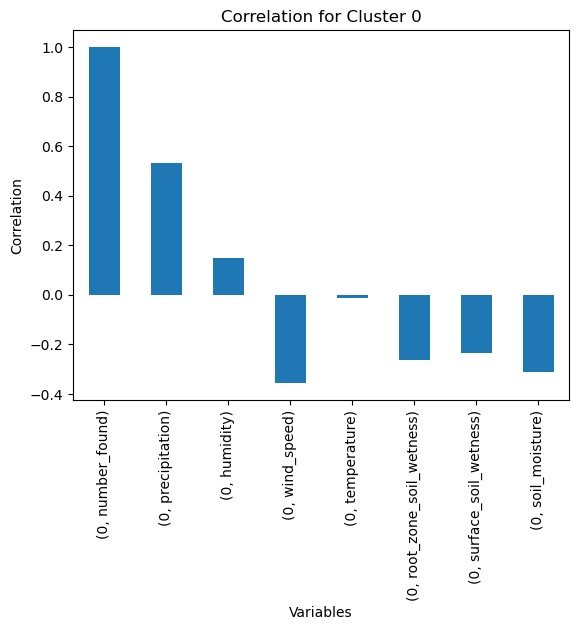

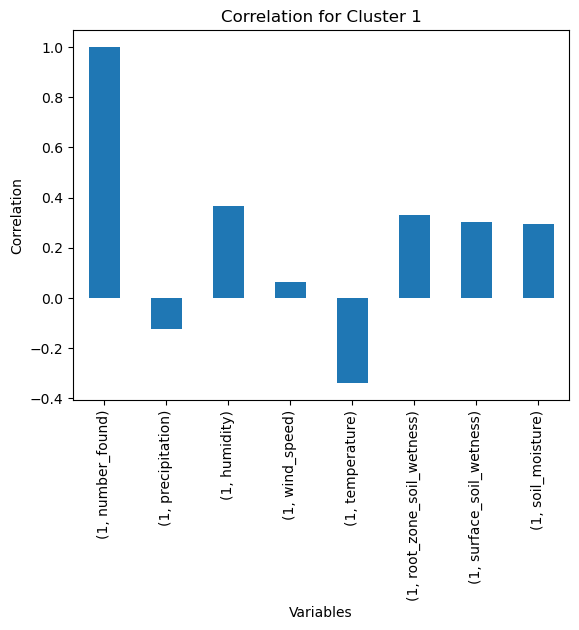

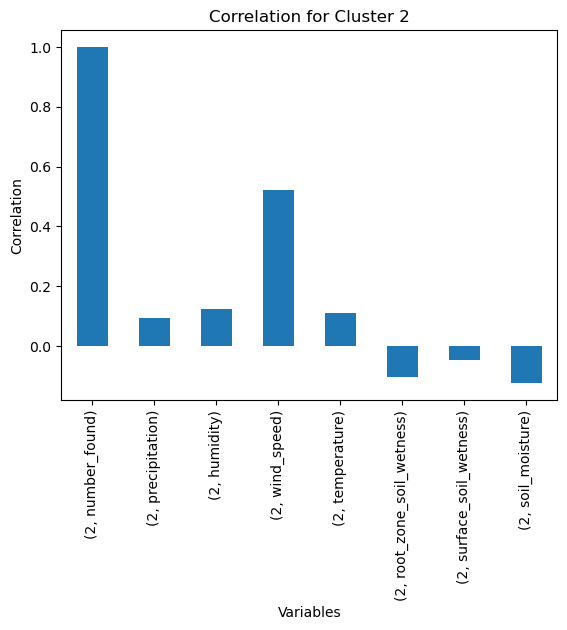

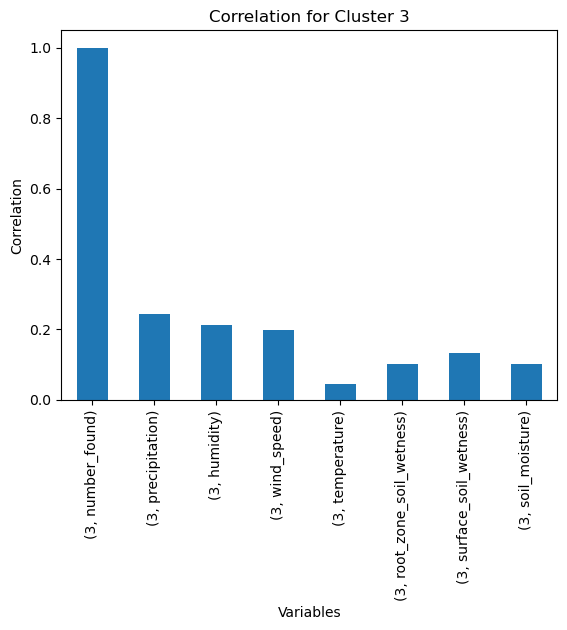

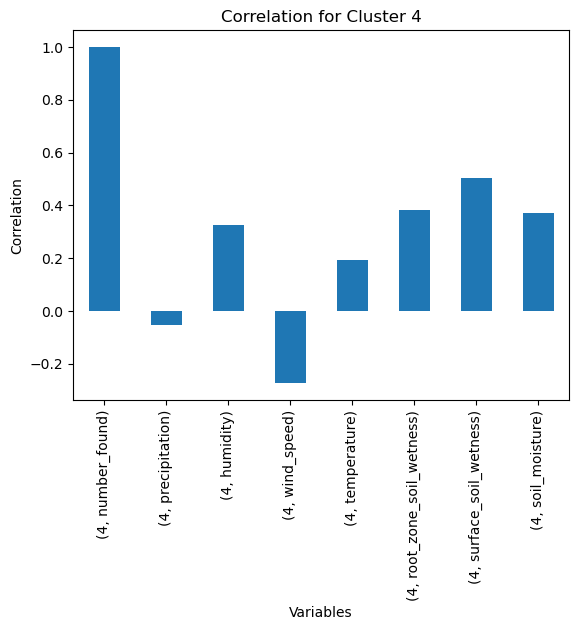

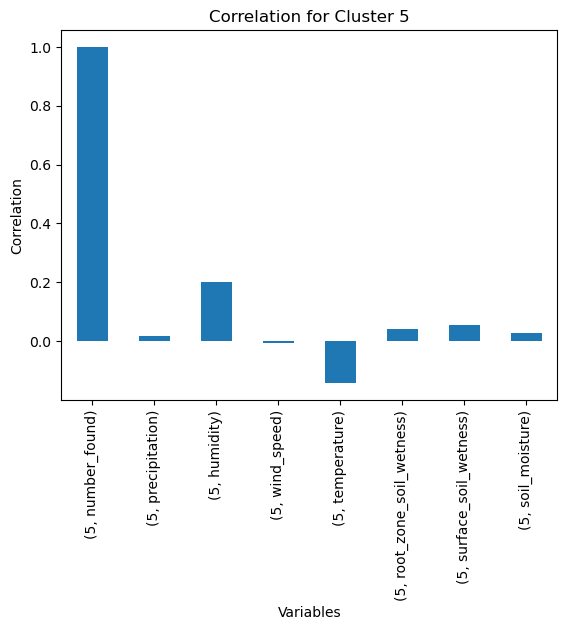

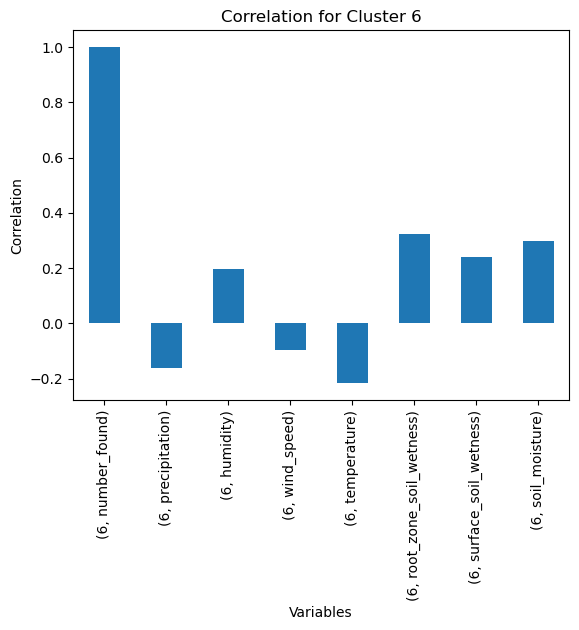

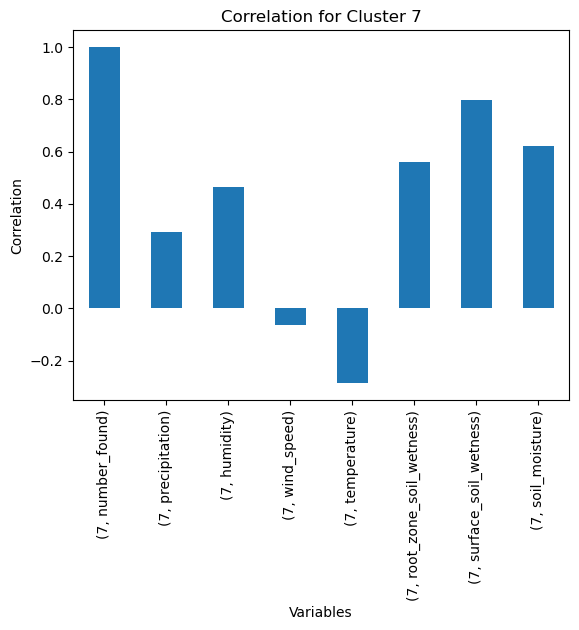

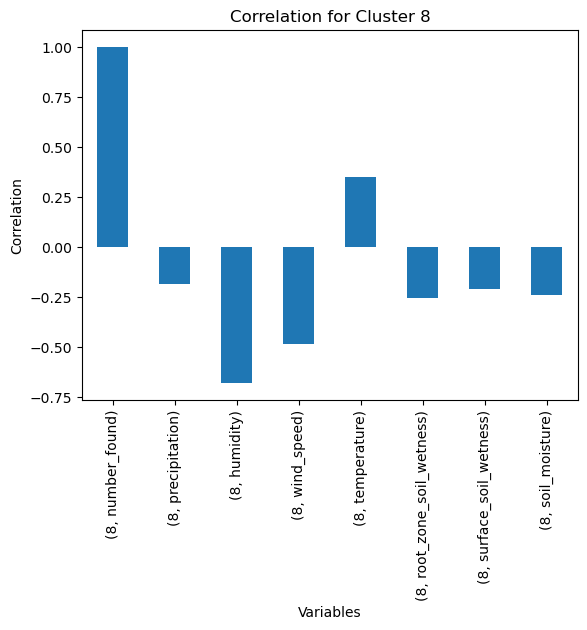

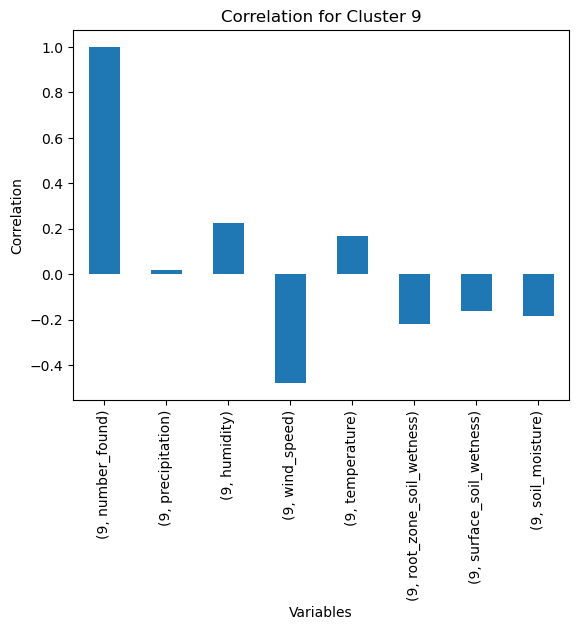

In [12]:
import seaborn as sns
correlation_df = merged_df.groupby('cluster').corr()['number_found']

# Iterate over the clusters
for cluster, df in correlation_df.groupby('cluster'):
    # Create a bar plot of the correlation values
    plt.figure()
    df.plot(kind='bar', title=f'Correlation for Cluster {cluster}')
    plt.xlabel('Variables')
    plt.ylabel('Correlation')
    plt.show()

    # Import the seaborn library

    # Calculate the correlation matrix
    correlation_matrix = merged_df.groupby('cluster').corr()

    # Create a heatmap of the correlation matrix
    plt.figure()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()
